In [1]:
# =============================================================================
# IMPROVED IMPORTS AND CONFIGURATION
# =============================================================================
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy.stats import pearsonr
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
)
from torch.utils.data import DataLoader, Dataset, TensorDataset

warnings.filterwarnings("ignore")

# Set style for better visualizations
plt.style.use("default")
sns.set_palette("husl")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print("✓ All libraries imported successfully")

# =============================================================================
# DATA LOADING WITH COMPREHENSIVE ERROR HANDLING
# =============================================================================
print("Loading multimodal data from pickle files...")

try:
    # Load all modalities
    with open("data/exported_modalities/mosi_text.pkl", "rb") as f:
        text_data = pickle.load(f)
    with open("data/exported_modalities/mosi_audio.pkl", "rb") as f:
        audio_data = pickle.load(f)
    with open("data/exported_modalities/mosi_vision.pkl", "rb") as f:
        video_data = pickle.load(f)

    print(
        f"✓ Text modality: Train{text_data['train']['data'].shape}, Valid{text_data['valid']['data'].shape}, Test{text_data['test']['data'].shape}"
    )
    print(
        f"✓ Audio modality: Train{audio_data['train']['data'].shape}, Valid{audio_data['valid']['data'].shape}, Test{audio_data['test']['data'].shape}"
    )
    print(
        f"✓ Video modality: Train{video_data['train']['data'].shape}, Valid{video_data['valid']['data'].shape}, Test{video_data['test']['data'].shape}"
    )

    # Comprehensive NaN handling and normalization
    for modality, data in [
        ("text", text_data),
        ("audio", audio_data),
        ("video", video_data),
    ]:
        for split in ["train", "valid", "test"]:
            # Replace NaN with 0
            if np.isnan(data[split]["data"]).any():
                nan_count = np.isnan(data[split]["data"]).sum()
                print(
                    f"Warning: {nan_count} NaN values found in {modality} {split} data. Replacing with 0."
                )
                data[split]["data"] = np.nan_to_num(data[split]["data"])

            # Normalize data
            data_mean = np.mean(data[split]["data"], axis=(0, 1), keepdims=True)
            data_std = np.std(data[split]["data"], axis=(0, 1), keepdims=True) + 1e-8
            data[split]["data"] = (data[split]["data"] - data_mean) / data_std

except Exception as e:
    print(f"Error loading data: {e}")
    raise

# Display original label statistics
print("\n" + "=" * 60)
print("ORIGINAL LABEL STATISTICS")
print("=" * 60)

for split_name in ["train", "valid", "test"]:
    labels = video_data[split_name]["labels"]
    print(
        f"{split_name.upper():6}: Range [{np.min(labels):.2f}, {np.max(labels):.2f}], "
        f"Mean: {np.mean(labels):.2f}, Std: {np.std(labels):.2f}, "
        f"Samples: {len(labels)}"
    )

Using device: cuda
✓ All libraries imported successfully
Loading multimodal data from pickle files...
✓ Text modality: Train(1283, 50, 300), Valid(214, 50, 300), Test(686, 50, 300)
✓ Audio modality: Train(1283, 50, 74), Valid(214, 50, 74), Test(686, 50, 74)
✓ Video modality: Train(1283, 50, 35), Valid(214, 50, 35), Test(686, 50, 35)

ORIGINAL LABEL STATISTICS
TRAIN : Range [-3.00, 3.00], Mean: 0.23, Std: 1.51, Samples: 1283
VALID : Range [-3.00, 3.00], Mean: 0.43, Std: 1.61, Samples: 214
TEST  : Range [-3.00, 3.00], Mean: -0.32, Std: 1.59, Samples: 686



ESSENTIAL DATA VISUALIZATION
Data dimensions:
Text train: data shape (1283, 50, 300), labels shape (1283, 1, 1)
Text valid: data shape (214, 50, 300), labels shape (214, 1, 1)
Text test: data shape (686, 50, 300), labels shape (686, 1, 1)
Audio train: data shape (1283, 50, 74), labels shape (1283, 1, 1)
Audio valid: data shape (214, 50, 74), labels shape (214, 1, 1)
Audio test: data shape (686, 50, 74), labels shape (686, 1, 1)
Video train: data shape (1283, 50, 35), labels shape (1283, 1, 1)
Video valid: data shape (214, 50, 35), labels shape (214, 1, 1)
Video test: data shape (686, 50, 35), labels shape (686, 1, 1)


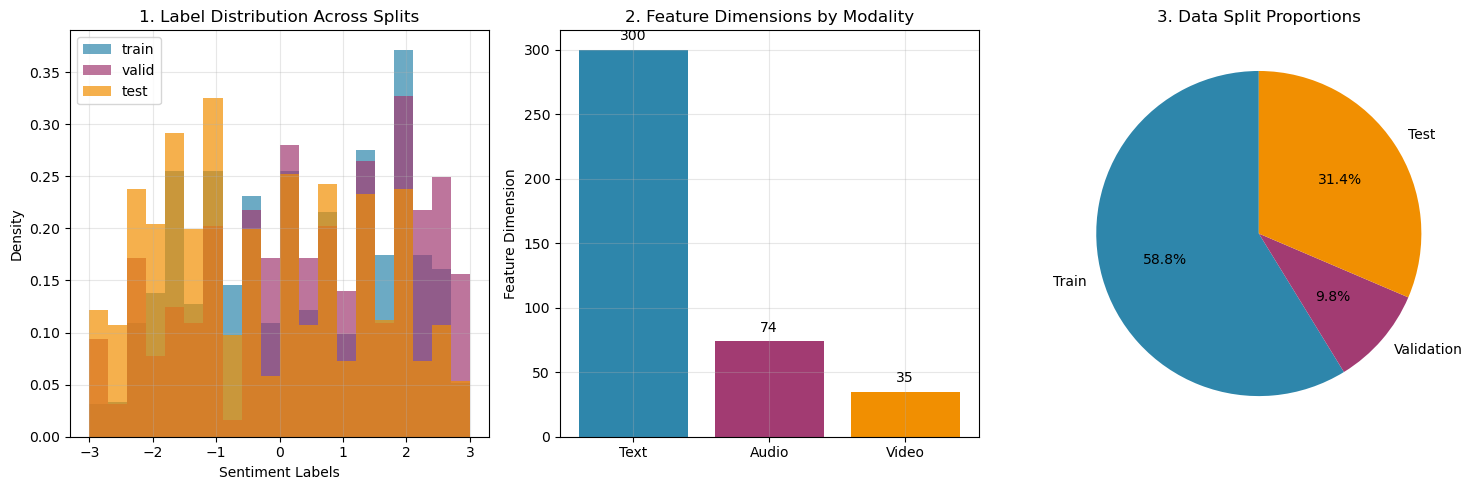


📊 LABEL STATISTICS:
  TRAIN : Mean =  0.235, Std =  1.510, Range = [-3.00,  3.00], N = 1283
  VALID : Mean =  0.432, Std =  1.611, Range = [-3.00,  3.00], N =  214
  TEST  : Mean = -0.317, Std =  1.588, Range = [-3.00,  3.00], N =  686

🔢 FEATURE DIMENSIONS:
  Text:  (1283, 50, 300)  
  Audio: (1283, 50, 74) 
  Video: (1283, 50, 35) 


In [2]:
# =============================================================================
# ESSENTIAL DATA VISUALIZATION (3 Key Plots)
# =============================================================================
print("\n" + "=" * 60)
print("ESSENTIAL DATA VISUALIZATION")
print("=" * 60)

# Check data dimensions first
print("Data dimensions:")
for modality_name, modality in [
    ("Text", text_data),
    ("Audio", audio_data),
    ("Video", video_data),
]:
    for split in ["train", "valid", "test"]:
        print(
            f"{modality_name} {split}: data shape {modality[split]['data'].shape}, labels shape {modality[split]['labels'].shape}"
        )

# Create a 1x3 grid of essential plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
colors = ["#2E86AB", "#A23B72", "#F18F01"]

# 1. Label Distribution across splits
ax = axes[0]
for i, split in enumerate(["train", "valid", "test"]):
    labels = video_data[split]["labels"]
    if labels.ndim > 1:
        labels = labels.flatten()
    ax.hist(labels, alpha=0.7, bins=20, label=split, color=colors[i], density=True)
ax.set_xlabel("Sentiment Labels")
ax.set_ylabel("Density")
ax.set_title("1. Label Distribution Across Splits")
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Feature Dimensions by Modality
ax = axes[1]
modality_dims = {
    "Text": text_data["train"]["data"].shape[-1],
    "Audio": audio_data["train"]["data"].shape[-1],
    "Video": video_data["train"]["data"].shape[-1],
}
bars = ax.bar(modality_dims.keys(), modality_dims.values(), color=colors)
ax.set_ylabel("Feature Dimension")
ax.set_title("2. Feature Dimensions by Modality")
for i, v in enumerate(modality_dims.values()):
    ax.text(i, v + 5, str(v), ha="center", va="bottom")
ax.grid(True, alpha=0.3)

# 3. Data Split Proportions
ax = axes[2]
split_counts = [
    len(text_data["train"]["labels"]),
    len(text_data["valid"]["labels"]),
    len(text_data["test"]["labels"]),
]
split_labels = ["Train", "Validation", "Test"]
ax.pie(
    split_counts, labels=split_labels, autopct="%1.1f%%", colors=colors, startangle=90
)
ax.set_title("3. Data Split Proportions")

plt.tight_layout()
plt.show()

print(f"\n📊 LABEL STATISTICS:")
for split in ["train", "valid", "test"]:
    labels = video_data[split]["labels"]
    if labels.ndim > 1:
        labels = labels.flatten()
    print(
        f"  {split.upper():6}: Mean = {np.mean(labels):6.3f}, Std = {np.std(labels):6.3f}, "
        f"Range = [{np.min(labels):5.2f}, {np.max(labels):5.2f}], N = {len(labels):4}"
    )

print(f"\n🔢 FEATURE DIMENSIONS:")
print(f"  Text:  {text_data['train']['data'].shape}  ")
print(f"  Audio: {audio_data['train']['data'].shape} ")
print(f"  Video: {video_data['train']['data'].shape} ")

In [3]:
# =============================================================================
# LABEL CONVERSION FUNCTIONS (ORIGINAL PAPER MAPPING)
# =============================================================================


def convert_to_binary(labels):
    """Convert continuous sentiment scores to binary labels (negative vs positive)"""
    binary_labels = np.zeros_like(labels, dtype=np.int64)
    binary_labels[labels > 0] = 1  # Positive
    binary_labels[labels <= 0] = 0  # Negative
    return binary_labels


def convert_to_5class(labels):
    """
    Convert continuous sentiment scores to 5 classes using TFN paper mapping:
    Class 0: Highly Negative (sentiment ≤ -1.5)
    Class 1: Negative (-1.5 < sentiment ≤ -0.5)
    Class 2: Neutral (-0.5 < sentiment ≤ 0.5)
    Class 3: Positive (0.5 < sentiment ≤ 1.5)
    Class 4: Highly Positive (sentiment > 1.5)
    """
    labels = labels.flatten()
    converted = np.zeros_like(labels, dtype=np.int64)

    converted[labels <= -1.5] = 0  # Highly Negative
    converted[(labels > -1.5) & (labels <= -0.5)] = 1  # Negative
    converted[(labels > -0.5) & (labels <= 0.5)] = 2  # Neutral
    converted[(labels > 0.5) & (labels <= 1.5)] = 3  # Positive
    converted[labels > 1.5] = 4  # Highly Positive

    return converted


# Convert labels for all tasks
print("\n" + "=" * 60)
print("LABEL CONVERSION FOR ALL TASKS")
print("=" * 60)

# Continuous labels (regression)
train_labels_reg = video_data["train"]["labels"].flatten()
valid_labels_reg = video_data["valid"]["labels"].flatten()
test_labels_reg = video_data["test"]["labels"].flatten()

# Binary classification labels
train_labels_binary = convert_to_binary(video_data["train"]["labels"])
valid_labels_binary = convert_to_binary(video_data["valid"]["labels"])
test_labels_binary = convert_to_binary(video_data["test"]["labels"])

# 5-class classification labels
train_labels_5class = convert_to_5class(video_data["train"]["labels"])
valid_labels_5class = convert_to_5class(video_data["valid"]["labels"])
test_labels_5class = convert_to_5class(video_data["test"]["labels"])

# Display distributions
class_names = ["Highly Negative", "Negative", "Neutral", "Positive", "Highly Positive"]
binary_names = ["Negative", "Positive"]

print("\n5-CLASS DISTRIBUTION:")
for split_name, labels in [
    ("TRAIN", train_labels_5class),
    ("VALID", valid_labels_5class),
    ("TEST", test_labels_5class),
]:
    print(f"\n{split_name}:")
    for class_idx, class_name in enumerate(class_names):
        count = int(np.sum(labels == class_idx))
        percentage = (count / len(labels)) * 100
        print(f"  {class_name:<18}: {count:>4} samples ({percentage:>5.1f}%)")

print("\nBINARY DISTRIBUTION:")
for split_name, labels in [
    ("TRAIN", train_labels_binary),
    ("VALID", valid_labels_binary),
    ("TEST", test_labels_binary),
]:
    print(f"\n{split_name}:")
    for class_idx, class_name in enumerate(binary_names):
        count = int(np.sum(labels == class_idx))
        percentage = (count / len(labels)) * 100
        print(f"  {class_name:<18}: {count:>4} samples ({percentage:>5.1f}%)")


LABEL CONVERSION FOR ALL TASKS

5-CLASS DISTRIBUTION:

TRAIN:
  Highly Negative   :  223 samples ( 17.4%)
  Negative          :  241 samples ( 18.8%)
  Neutral           :  233 samples ( 18.2%)
  Positive          :  229 samples ( 17.8%)
  Highly Positive   :  357 samples ( 27.8%)

VALID:
  Highly Negative   :   33 samples ( 15.4%)
  Negative          :   26 samples ( 12.1%)
  Neutral           :   48 samples ( 22.4%)
  Positive          :   39 samples ( 18.2%)
  Highly Positive   :   68 samples ( 31.8%)

TEST:
  Highly Negative   :  202 samples ( 29.4%)
  Negative          :  148 samples ( 21.6%)
  Neutral           :  103 samples ( 15.0%)
  Positive          :  114 samples ( 16.6%)
  Highly Positive   :  119 samples ( 17.3%)

BINARY DISTRIBUTION:

TRAIN:
  Negative          :  605 samples ( 47.2%)
  Positive          :  678 samples ( 52.8%)

VALID:
  Negative          :   91 samples ( 42.5%)
  Positive          :  123 samples ( 57.5%)

TEST:
  Negative          :  409 samples ( 59.6

In [4]:
# =============================================================================
# CELL 4: DATA LOADERS
# =============================================================================


class MultimodalDataset(Dataset):
    """
    Improved Dataset class with better preprocessing and normalization
    """

    def __init__(self, text_data, audio_data, video_data, labels, task="regression"):
        self.text_data = text_data
        self.audio_data = audio_data
        self.video_data = video_data
        self.labels = labels
        self.task = task

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if self.task == "regression":
            label = torch.FloatTensor([self.labels[idx]])
        else:  # classification tasks
            label = torch.LongTensor([self.labels[idx]])

        # Convert to tensors and ensure no NaN values
        text_tensor = torch.FloatTensor(self.text_data[idx])
        audio_tensor = torch.FloatTensor(self.audio_data[idx])
        video_tensor = torch.FloatTensor(self.video_data[idx])

        # Replace any remaining NaN values
        if torch.isnan(text_tensor).any():
            text_tensor = torch.nan_to_num(text_tensor)
        if torch.isnan(audio_tensor).any():
            audio_tensor = torch.nan_to_num(audio_tensor)
        if torch.isnan(video_tensor).any():
            video_tensor = torch.nan_to_num(video_tensor)

        return {
            "text": text_tensor,
            "audio": audio_tensor,
            "video": video_tensor,
            "label": label.squeeze(),
        }


def create_data_loaders(task="regression", batch_size=32):
    """Create data loaders for specific task with proper label selection"""

    # Select appropriate labels based on task
    if task == "regression":
        train_labels = train_labels_reg
        valid_labels = valid_labels_reg
        test_labels = test_labels_reg
        output_dim = 1
    elif task == "binary":
        train_labels = train_labels_binary
        valid_labels = valid_labels_binary
        test_labels = test_labels_binary
        output_dim = 2
    elif task == "5class":
        train_labels = train_labels_5class
        valid_labels = valid_labels_5class
        test_labels = test_labels_5class
        output_dim = 5

    # Create datasets
    train_dataset = MultimodalDataset(
        text_data["train"]["data"],
        audio_data["train"]["data"],
        video_data["train"]["data"],
        train_labels,
        task,
    )

    valid_dataset = MultimodalDataset(
        text_data["valid"]["data"],
        audio_data["valid"]["data"],
        video_data["valid"]["data"],
        valid_labels,
        task,
    )

    test_dataset = MultimodalDataset(
        text_data["test"]["data"],
        audio_data["test"]["data"],
        video_data["test"]["data"],
        test_labels,
        task,
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=0
    )
    valid_loader = DataLoader(
        valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=0
    )

    print(f"✓ Data loaders created for {task} task (output_dim: {output_dim})")
    print(f"  Train: {len(train_dataset):4} samples")
    print(f"  Valid: {len(valid_dataset):4} samples")
    print(f"  Test:  {len(test_dataset):4} samples")

    return train_loader, valid_loader, test_loader, output_dim


# Test data loading
print("\n" + "=" * 50)
print("DATA LOADER TESTING")
print("=" * 50)

for task in ["regression", "binary", "5class"]:
    train_loader, val_loader, test_loader, output_dim = create_data_loaders(
        task=task, batch_size=8
    )
    sample_batch = next(iter(train_loader))
    print(
        f"{task.upper():12} - Text: {sample_batch['text'].shape}, "
        f"Audio: {sample_batch['audio'].shape}, Video: {sample_batch['video'].shape}, "
        f"Labels: {sample_batch['label'].shape}"
    )


DATA LOADER TESTING
✓ Data loaders created for regression task (output_dim: 1)
  Train: 1283 samples
  Valid:  214 samples
  Test:   686 samples
REGRESSION   - Text: torch.Size([8, 50, 300]), Audio: torch.Size([8, 50, 74]), Video: torch.Size([8, 50, 35]), Labels: torch.Size([8])
✓ Data loaders created for binary task (output_dim: 2)
  Train: 1283 samples
  Valid:  214 samples
  Test:   686 samples
BINARY       - Text: torch.Size([8, 50, 300]), Audio: torch.Size([8, 50, 74]), Video: torch.Size([8, 50, 35]), Labels: torch.Size([8])
✓ Data loaders created for 5class task (output_dim: 5)
  Train: 1283 samples
  Valid:  214 samples
  Test:   686 samples
5CLASS       - Text: torch.Size([8, 50, 300]), Audio: torch.Size([8, 50, 74]), Video: torch.Size([8, 50, 35]), Labels: torch.Size([8])


In [5]:
# =============================================================================
# REVISED CELL 5: PROPER TFN ARCHITECTURE WITH PAPER-ACCURATE ABLATIONS
# =============================================================================


class TemporalAttention(nn.Module):
    """
    Modular temporal attention block.
    - Expects input of shape (B, T, F).
    - Outputs a weighted sum over time -> (B, F).
    - If return_weights=True, also returns attention weights shape (B, T).
    """

    def __init__(self, input_dim, hidden_dim=None):
        super(TemporalAttention, self).__init__()
        hidden_dim = hidden_dim or max(1, input_dim // 2)
        self.score_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1),  # scalar score per timestep
        )

    def forward(self, x, return_weights=False):
        """
        x: (B, T, F)
        returns: (B, F)  or ((B, F), (B, T)) if return_weights True
        """
        if x.dim() != 3:
            raise ValueError("TemporalAttention expects 3D input (B, T, F)")
        # compute scores: (B, T, 1) -> squeeze -> (B, T)
        scores = self.score_net(x).squeeze(-1)  # (B, T)
        weights = torch.softmax(scores, dim=1)  # (B, T)
        weights_unsq = weights.unsqueeze(-1)  # (B, T, 1)
        attended = torch.sum(weights_unsq * x, dim=1)  # (B, F)
        if return_weights:
            return attended, weights
        return attended


class RevisedSubNet(nn.Module):
    """
    Revised Subnetwork with optional internal TemporalAttention.

    If attention=True the module creates an internal TemporalAttention instance
    (with hidden_dim = max(1, in_size//2) unless attention_hidden is provided)
    and uses it to collapse temporal dimension when input is 3D (B, T, F).
    Otherwise it falls back to mean pooling across time.
    """
    def __init__(self, in_size, hidden_size, dropout, attention: bool = False, attention_hidden: int | None = None):
        super(RevisedSubNet, self).__init__()
        self.use_attention = bool(attention)
        self.attention = None
        if self.use_attention:
            # TemporalAttention must be defined in scope
            attn_h = attention_hidden or max(1, in_size // 2)
            self.attention = TemporalAttention(input_dim=in_size, hidden_dim=attn_h)

        self.norm = nn.BatchNorm1d(in_size)
        self.drop = nn.Dropout(p=dropout)
        self.linear_1 = nn.Linear(in_size, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, hidden_size)
        self.linear_3 = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        """
        x: (B, T, F) or (B, F)
        If 3D and attention enabled -> apply attention to collapse to (B, F).
        If 3D and attention disabled -> mean-pool to (B, F).
        """
        # temporal collapse
        if x.dim() == 3:
            if self.use_attention and (self.attention is not None):
                # attention expects (B, T, F)
                x = self.attention(x)
            else:
                x = x.mean(dim=1)

        # x is now (B, F)
        if x.size(0) == 1:
            normed = x  # avoid BatchNorm running-stat issues for batch=1
        else:
            normed = self.norm(x)

        dropped = self.drop(normed)
        y = F.relu(self.linear_1(dropped))
        y = F.relu(self.linear_2(y))
        y = F.relu(self.linear_3(y))
        return y


class RevisedTextSubNet(nn.Module):
    """
    Revised LSTM subnetwork with optional temporal attention over RNN outputs.

    - If attention_module is provided, or attention=True, attention is applied to
      the RNN sequence outputs (B, T, H*) to produce an attended vector (B, H*).
    - Otherwise the final hidden state is used (as before).
    """
    def __init__(
        self,
        in_size,
        hidden_size,
        out_size,
        num_layers=1,
        dropout=0.2,
        bidirectional=False,
        attention: bool = False,
        attention_hidden: int | None = None,
        attention_module: nn.Module | None = None,
    ):
        super(RevisedTextSubNet, self).__init__()
        self.rnn = nn.LSTM(
            in_size,
            hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=bidirectional,
            batch_first=True,
        )
        self.dropout = nn.Dropout(dropout)
        self.bidirectional = bidirectional

        # rnn_output_size is the feature-size produced per timestep by the RNN
        rnn_output_size = hidden_size * 2 if bidirectional else hidden_size
        self.rnn_output_size = rnn_output_size

        # linear that maps collapsed representation -> out_size (same as before)
        self.linear_1 = nn.Linear(rnn_output_size, out_size)

        # attention: either provided externally or created here when attention=True
        if attention_module is not None:
            self.attention = attention_module
        elif attention:
            # requires TemporalAttention class to be defined in scope
            self.attention = TemporalAttention(input_dim=rnn_output_size, hidden_dim=attention_hidden)
        else:
            self.attention = None

        self._initialize_weights()

    def _initialize_weights(self):
        for name, param in self.rnn.named_parameters():
            if "weight" in name:
                nn.init.orthogonal_(param)
            elif "bias" in name:
                nn.init.constant_(param, 0)
                # Set forget-gate bias to 1 (LSTM ordering: i, f, g, o)
                if param.numel() == 4 * self.rnn.hidden_size:
                    param.data[self.rnn.hidden_size : 2 * self.rnn.hidden_size] = 1.0

    def forward(self, x):
        """
        x: (B, T, in_size)
        returns: (B, out_size)
        """
        # run rnn
        self.rnn.flatten_parameters()
        seq_out, (hidden, cell) = self.rnn(x)  # seq_out: (B, T, H*) ; hidden: (num_layers * num_dirs, B, hidden_size)

        if self.attention is not None:
            # apply attention over seq_out -> (B, H*)
            # TemporalAttention expects (B, T, F) where F == rnn_output_size
            attended = self.attention(seq_out)  # (B, H*)
            h = self.dropout(attended)
        else:
            # previous behavior: use final hidden state
            if self.bidirectional:
                # last layer, concat forward/backward hidden states
                h_cat = torch.cat([hidden[-2], hidden[-1]], dim=1)  # (B, 2*hidden)
            else:
                h_cat = hidden[-1]  # (B, hidden)
            h = self.dropout(h_cat)

        return self.linear_1(h)


class RevisedTensorFusion(nn.Module):
    """
    PAPER-ACCURATE Tensor Fusion following TFN semantics:
    - full: (L+1)*(V+1)*(A+1) with appended 1s (TFN cube)
    - notrimodal: unimodal + bimodal (no 3-way interactions)
    - bimodal: only bimodal interactions
    - trimodal: only trimodal (3-way) interactions
    - unimodal: only single modalities
    """

    def __init__(self):
        super(RevisedTensorFusion, self).__init__()

    def forward(self, z_l, z_v, z_a, mode="full"):
        B = z_l.size(0)
        L, V, A = z_l.size(1), z_v.size(1), z_a.size(1)

        # Unimodal components (paper: z_l, z_v, z_a)
        if mode == "unimodal":
            return torch.cat([z_l, z_v, z_a], dim=1)

        # Bimodal components (paper: pairwise products only)
        elif mode == "bimodal":
            lv = torch.bmm(z_l.unsqueeze(2), z_v.unsqueeze(1)).view(B, -1)  # (B, L*V)
            la = torch.bmm(z_l.unsqueeze(2), z_a.unsqueeze(1)).view(B, -1)  # (B, L*A)
            va = torch.bmm(z_v.unsqueeze(2), z_a.unsqueeze(1)).view(B, -1)  # (B, V*A)
            return torch.cat([lv, la, va], dim=1)

        # Trimodal components (paper: 3-way product only)
        elif mode == "trimodal":
            # Compute 3-way outer product: z_l ⊗ z_v ⊗ z_a
            lv = torch.bmm(z_l.unsqueeze(2), z_v.unsqueeze(1))  # (B, L, V)
            lva = torch.bmm(lv.view(B, L * V, 1), z_a.unsqueeze(1)).view(
                B, -1
            )  # (B, L*V*A)
            return lva

        # NoTrimodal: unimodal + bimodal (paper: full tensor without 3-way)
        elif mode == "notrimodal":
            unimodal = torch.cat([z_l, z_v, z_a], dim=1)
            lv = torch.bmm(z_l.unsqueeze(2), z_v.unsqueeze(1)).view(B, -1)
            la = torch.bmm(z_l.unsqueeze(2), z_a.unsqueeze(1)).view(B, -1)
            va = torch.bmm(z_v.unsqueeze(2), z_a.unsqueeze(1)).view(B, -1)
            bimodal = torch.cat([lv, la, va], dim=1)
            return torch.cat([unimodal, bimodal], dim=1)

        # Full TFN: unimodal + bimodal + trimodal with bias (paper's full model)
        elif mode == "full":
            # Append 1s for bias terms (TFN cube construction)
            ones = torch.ones(B, 1, device=z_l.device)
            zl_p = torch.cat([ones, z_l], dim=1)  # (B, L+1)
            zv_p = torch.cat([ones, z_v], dim=1)  # (B, V+1)
            za_p = torch.cat([ones, z_a], dim=1)  # (B, A+1)

            # Full outer product: (L+1)*(V+1)*(A+1)
            fusion_tensor = torch.bmm(
                zl_p.unsqueeze(2), zv_p.unsqueeze(1)
            )  # (B, L+1, V+1)
            fusion_tensor = fusion_tensor.view(B, (L + 1) * (V + 1), 1)
            fusion_tensor = torch.bmm(
                fusion_tensor, za_p.unsqueeze(1)
            )  # (B, (L+1)*(V+1), A+1)
            return fusion_tensor.view(B, -1)

        else:
            raise ValueError(f"Unknown fusion mode: {mode}")


print("✅ Paper-accurate TFN fusion ready!")

✅ Paper-accurate TFN fusion ready!


In [6]:
# --- minimal CrossModalAttention (single-head) ---
class CrossModalAttention(nn.Module):
    def __init__(self, query_dim, key_dim, out_dim=None, hidden_dim=None, attn_dropout=0.0):
        super(CrossModalAttention, self).__init__()
        if hidden_dim is None:
            hidden_dim = min(query_dim, key_dim)
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim or key_dim
        self.q_proj = nn.Linear(query_dim, hidden_dim, bias=False)
        self.k_proj = nn.Linear(key_dim, hidden_dim, bias=False)
        self.v_proj = nn.Linear(key_dim, self.out_dim, bias=False)
        self.attn_dropout = nn.Dropout(attn_dropout) if attn_dropout > 0 else nn.Identity()

    def forward(self, query, key, value=None, pool=None, mask=None):
        # query: (B, Tq, Dq) -- we'll typically pass Tq=1
        # key:   (B, Tk, Dk) -- we'll typically pass Tk=1
        if value is None:
            value = key
        Q = self.q_proj(query)   # (B, Tq, H)
        K = self.k_proj(key)     # (B, Tk, H)
        V = self.v_proj(value)   # (B, Tk, Dout)
        scores = torch.bmm(Q, K.transpose(1, 2)) / (self.hidden_dim ** 0.5)  # (B, Tq, Tk)
        if mask is not None:
            scores = scores + mask
        weights = torch.softmax(scores, dim=-1)
        weights = self.attn_dropout(weights)
        attended = torch.bmm(weights, V)  # (B, Tq, Dout)
        if pool is None:
            out = attended
        elif pool == 'first':
            out = attended[:, 0, :]
        elif pool == 'mean':
            out = attended.mean(dim=1)
        elif pool == 'max':
            out, _ = attended.max(dim=1)
        else:
            raise ValueError("pool must be one of {None, 'first', 'mean', 'max'}")
        return out

# --- RevisedTFN with simple cross-attention option ---
class RevisedTFN(nn.Module):
    """
    Revised TFN model with optional light cross-modal attention.
    Set use_cross=True to enable cross-attention between modalities.
    """
    def __init__(self, input_dims, hidden_dims, text_out, dropouts, post_fusion_dim, 
                 ablation_mode='full', output_dim=1, use_cross: bool = True):
        super(RevisedTFN, self).__init__()
        
        self.ablation_mode = ablation_mode
        self.output_dim = output_dim
        self.use_cross = bool(use_cross)
        
        # Input dimensions
        self.audio_in, self.video_in, self.text_in = input_dims
        self.audio_hidden, self.video_hidden, self.text_hidden = hidden_dims
        self.text_out = text_out
        
        # Subnetworks (internal temporal attention enabled)
        self.audio_subnet = RevisedSubNet(self.audio_in, self.audio_hidden, dropouts[0], attention=True)
        self.video_subnet = RevisedSubNet(self.video_in, self.video_hidden, dropouts[1], attention=True)
        self.text_subnet = RevisedTextSubNet(self.text_in, self.text_hidden, self.text_out, 
                                           dropout=dropouts[2], attention=True)
        
        # Cross-modal attention modules (simple single-head) - create only if requested
        if self.use_cross:
            # audio queries attend to video keys/values -> produce audio-conditioned-on-video
            self.cross_av = CrossModalAttention(query_dim=self.audio_hidden, key_dim=self.video_hidden, out_dim=self.audio_hidden)
            # video queries attend to text keys/values -> produce video-conditioned-on-text
            self.cross_vt = CrossModalAttention(query_dim=self.video_hidden, key_dim=self.text_out, out_dim=self.video_hidden)
            # text queries attend to audio keys/values -> produce text-conditioned-on-audio
            # note: text_out is the post-LSTM mapped dim (what RevisedTextSubNet outputs)
            self.cross_ta = CrossModalAttention(query_dim=self.text_out, key_dim=self.audio_hidden, out_dim=self.text_out)
        
        # Tensor fusion (for multimodal models)
        if ablation_mode in ['full', 'bimodal', 'trimodal', 'notrimodal']:
            self.tensor_fusion = RevisedTensorFusion()
        
        # Calculate fusion dimension according to paper (unchanged)
        self.fusion_dim = self._get_paper_fusion_dim()
        
        print(f"🔧 Building TFN-{ablation_mode}:")
        print(f"   Input dims: A{self.audio_in}/V{self.video_in}/T{self.text_in}")
        print(f"   Hidden dims: A{self.audio_hidden}/V{self.video_hidden}/T{self.text_hidden}")  
        print(f"   Fusion dim: {self.fusion_dim}")
        
        # Post-fusion network
        self.post_fusion_dropout = nn.Dropout(p=dropouts[3])
        self.post_fusion_layer_1 = nn.Linear(self.fusion_dim, post_fusion_dim)
        self.post_fusion_layer_2 = nn.Linear(post_fusion_dim, post_fusion_dim)
        self.post_fusion_layer_3 = nn.Linear(post_fusion_dim, output_dim)
        
        # Output scaling for regression
        if output_dim == 1:
            self.output_range = nn.Parameter(torch.FloatTensor([6]), requires_grad=False)
            self.output_shift = nn.Parameter(torch.FloatTensor([-3]), requires_grad=False)
        
    def _get_paper_fusion_dim(self):
        """Calculate fusion dimensions according to TFN paper semantics"""
        L, V, A = self.text_out, self.video_hidden, self.audio_hidden
        
        if self.ablation_mode == 'language':
            return L
        elif self.ablation_mode == 'visual':
            return V  
        elif self.ablation_mode == 'acoustic':
            return A
        elif self.ablation_mode == 'early' or self.ablation_mode == 'unimodal':
            return L + V + A  # Early fusion = unimodal concatenation
        elif self.ablation_mode == 'bimodal':
            return L*V + L*A + V*A  # Only pairwise products
        elif self.ablation_mode == 'trimodal':
            return L*V*A  # Only 3-way product
        elif self.ablation_mode == 'notrimodal':
            return (L + V + A) + (L*V + L*A + V*A)  # Unimodal + bimodal
        elif self.ablation_mode == 'full':
            return (L+1) * (V+1) * (A+1)  # Full TFN cube with bias
        else:
            return (L+1) * (V+1) * (A+1)
    
    def forward(self, text_x, audio_x, video_x):
        # Extract modality features (each returns (B, D))
        audio_h = self.audio_subnet(audio_x)   # (B, audio_hidden)
        video_h = self.video_subnet(video_x)   # (B, video_hidden)
        text_h  = self.text_subnet(text_x)     # (B, text_out)
        
        # OPTIONAL: Cross-modal attention enrichments (residual addition)
        if self.use_cross:
            # unsqueeze to (B, 1, D) for cross-attention; pool='first' returns (B, D)
            audio_enriched = self.cross_av(audio_h.unsqueeze(1), video_h.unsqueeze(1), pool='first')
            video_enriched = self.cross_vt(video_h.unsqueeze(1), text_h.unsqueeze(1), pool='first')
            text_enriched  = self.cross_ta(text_h.unsqueeze(1), audio_h.unsqueeze(1), pool='first')
            # residual add (keeps dims unchanged so fusion_dim stays valid)
            audio_h = audio_h + audio_enriched
            video_h = video_h + video_enriched
            text_h  = text_h  + text_enriched
        
        # Apply fusion based on ablation mode
        if self.ablation_mode in ['language', 'visual', 'acoustic']:
            if self.ablation_mode == 'language':
                fusion = text_h
            elif self.ablation_mode == 'visual':
                fusion = video_h
            else:  # acoustic
                fusion = audio_h
        elif self.ablation_mode == 'early' or self.ablation_mode == 'unimodal':
            # Early fusion = unimodal concatenation
            fusion = torch.cat([text_h, video_h, audio_h], dim=1)
        elif self.ablation_mode in ['bimodal', 'trimodal', 'notrimodal', 'full']:
            fusion = self.tensor_fusion(text_h, video_h, audio_h, mode=self.ablation_mode)
        else:
            fusion = self.tensor_fusion(text_h, video_h, audio_h, mode='full')
        
        # Post-fusion network
        if self.ablation_mode == 'full':
            fusion = self.post_fusion_dropout(fusion)
            
        post_fusion_y_1 = F.relu(self.post_fusion_layer_1(fusion))
        post_fusion_y_2 = F.relu(self.post_fusion_layer_2(post_fusion_y_1))
        
        # Output handling
        if self.output_dim == 1:  # Regression
            post_fusion_y_3 = torch.sigmoid(self.post_fusion_layer_3(post_fusion_y_2))
            output = post_fusion_y_3 * self.output_range + self.output_shift
        else:  # Classification
            output = self.post_fusion_layer_3(post_fusion_y_2)
        
        return output


In [7]:
# =============================================================================
# REVISED CELL 7: TESTING PAPER-ACCURATE IMPLEMENTATION (FIXED)
# =============================================================================


def test_paper_accurate_fusion():
    """Test that our implementation matches TFN paper dimensions"""
    print("\n🧪 TESTING PAPER-ACCURATE FUSION DIMENSIONS")
    print("=" * 60)

    # Test dimensions from paper: L=64, V=16, A=4
    L, V, A = 64, 16, 4
    batch_size = 2

    # Create test embeddings
    z_l = torch.randn(batch_size, L)
    z_v = torch.randn(batch_size, V)
    z_a = torch.randn(batch_size, A)

    fusion = RevisedTensorFusion()

    # Test all fusion modes
    test_cases = [
        ("unimodal", L + V + A),
        ("bimodal", L * V + L * A + V * A),
        ("trimodal", L * V * A),
        ("notrimodal", (L + V + A) + (L * V + L * A + V * A)),
        ("full", (L + 1) * (V + 1) * (A + 1)),
    ]

    print(f"Base dimensions: L={L}, V={V}, A={A}")
    print("-" * 40)

    for mode, expected_dim in test_cases:
        output = fusion(z_l, z_v, z_a, mode=mode)
        actual_dim = output.shape[1]
        status = "✅" if actual_dim == expected_dim else "❌"
        print(
            f"{status} {mode:12}: expected {expected_dim:5}, got {actual_dim:5} - {status}"
        )

    # Verify paper's claim about components
    print("\n📊 PAPER CLAIM VERIFICATION:")
    print("TFN = Unimodal + Bimodal + Trimodal + Bias terms")
    unimodal_dim = L + V + A  # FIXED: Changed from early_dim to unimodal_dim
    bimodal_dim = L * V + L * A + V * A
    trimodal_dim = L * V * A
    bias_terms = (
        1
        + L
        + V
        + A
        + L * V
        + L * A
        + V * A
        + L * V * A
        - (unimodal_dim + bimodal_dim + trimodal_dim)
    )

    full_manual = unimodal_dim + bimodal_dim + trimodal_dim + bias_terms
    full_actual = (L + 1) * (V + 1) * (A + 1)

    print(f"   Unimodal: {unimodal_dim}")
    print(f"   Bimodal:  {bimodal_dim}")
    print(f"   Trimodal: {trimodal_dim}")
    print(f"   Bias:     {bias_terms}")
    print(
        f"   Total:    {full_manual} = {full_actual} ✅"
        if full_manual == full_actual
        else f"   Total:    {full_manual} ≠ {full_actual} ❌"
    )


# Run the test
test_paper_accurate_fusion()


def get_paper_accurate_model(model_name, output_dim=1):
    """
    Factory function with paper-accurate dimensions
    """
    # MOSI dataset dimensions
    input_dims = (74, 35, 300)  # (audio, video, text)

    # TFN paper dimensions (Table 2)
    hidden_dims = (4, 16, 128)  # (audio_hidden, video_hidden, text_hidden)
    text_out = 64  # From paper: L=64
    dropouts = (0.3, 0.3, 0.3, 0.3)
    post_fusion_dim = 32

    print(f"\n🏗️  Building {model_name} (paper-accurate)...")

    # Model mapping - EARLY FUSION NOW WORKS
    if model_name == "tfn_language":
        model = RevisedTFN(
            input_dims,
            hidden_dims,
            text_out,
            dropouts,
            post_fusion_dim,
            "language",
            output_dim,
        )
    elif model_name == "tfn_visual":
        model = RevisedTFN(
            input_dims,
            hidden_dims,
            text_out,
            dropouts,
            post_fusion_dim,
            "visual",
            output_dim,
        )
    elif model_name == "tfn_acoustic":
        model = RevisedTFN(
            input_dims,
            hidden_dims,
            text_out,
            dropouts,
            post_fusion_dim,
            "acoustic",
            output_dim,
        )
    elif model_name == "tfn_early":
        model = RevisedTFN(
            input_dims,
            hidden_dims,
            text_out,
            dropouts,
            post_fusion_dim,
            "early",
            output_dim,
        )  # NOW WORKS
    elif model_name == "tfn_bimodal":
        model = RevisedTFN(
            input_dims,
            hidden_dims,
            text_out,
            dropouts,
            post_fusion_dim,
            "bimodal",
            output_dim,
        )
    elif model_name == "tfn_trimodal":
        model = RevisedTFN(
            input_dims,
            hidden_dims,
            text_out,
            dropouts,
            post_fusion_dim,
            "trimodal",
            output_dim,
        )
    elif model_name == "tfn_notrimodal":
        model = RevisedTFN(
            input_dims,
            hidden_dims,
            text_out,
            dropouts,
            post_fusion_dim,
            "notrimodal",
            output_dim,
        )
    elif model_name == "tfn_full":
        model = RevisedTFN(
            input_dims,
            hidden_dims,
            text_out,
            dropouts,
            post_fusion_dim,
            "full",
            output_dim,
        )
    else:
        raise ValueError(f"Unknown model: {model_name}")

    num_params = sum(p.numel() for p in model.parameters())
    print(f"✅ {model_name} built: {num_params:,} params, output_dim: {output_dim}")

    return model.to(device)


# Test all paper models including early fusion
print("\n" + "=" * 70)
print("TESTING ALL PAPER MODELS INCLUDING EARLY FUSION")
print("=" * 70)

batch_size = 16
test_text = torch.randn(batch_size, 50, 300).to(device)
test_audio = torch.randn(batch_size, 50, 74).to(device)
test_video = torch.randn(batch_size, 50, 35).to(device)

paper_models = [
    "tfn_language",
    "tfn_visual",
    "tfn_acoustic",  # Unimodal
    "tfn_early",  # Early fusion - NOW WORKS
    "tfn_bimodal",
    "tfn_trimodal",
    "tfn_notrimodal",  # Multimodal ablations
    "tfn_full",  # Full model
]

for model_name in paper_models:
    try:
        model = get_paper_accurate_model(model_name, output_dim=1)
        with torch.no_grad():
            output = model(test_text, test_audio, test_video)
        print(f"✅ {model_name:15}: output shape {output.shape}")
    except Exception as e:
        print(f"❌ {model_name:15}: {e}")

print(f"\n🎯 PAPER-ACCURATE IMPLEMENTATION READY!")
print("   All TFN ablation variants now match paper semantics")
print("   ✅ Early fusion now working as unimodal concatenation")


🧪 TESTING PAPER-ACCURATE FUSION DIMENSIONS
Base dimensions: L=64, V=16, A=4
----------------------------------------
✅ unimodal    : expected    84, got    84 - ✅
✅ bimodal     : expected  1344, got  1344 - ✅
✅ trimodal    : expected  4096, got  4096 - ✅
✅ notrimodal  : expected  1428, got  1428 - ✅
✅ full        : expected  5525, got  5525 - ✅

📊 PAPER CLAIM VERIFICATION:
TFN = Unimodal + Bimodal + Trimodal + Bias terms
   Unimodal: 84
   Bimodal:  1344
   Trimodal: 4096
   Bias:     1
   Total:    5525 = 5525 ✅

TESTING ALL PAPER MODELS INCLUDING EARLY FUSION

🏗️  Building tfn_language (paper-accurate)...
🔧 Building TFN-language:
   Input dims: A74/V35/T300
   Hidden dims: A4/V16/T128
   Fusion dim: 64
✅ tfn_language built: 248,005 params, output_dim: 1
✅ tfn_language   : output shape torch.Size([16, 1])

🏗️  Building tfn_visual (paper-accurate)...
🔧 Building TFN-visual:
   Input dims: A74/V35/T300
   Hidden dims: A4/V16/T128
   Fusion dim: 16
✅ tfn_visual built: 246,469 params, out

In [8]:
# =============================================================================
# CELL 8: REVISED TRAINING PIPELINE WITH CUDA ERROR HANDLING
# =============================================================================


def train_revised_model(
    model,
    train_loader,
    val_loader,
    task="regression",
    epochs=100,
    model_name="TFN",
    patience=20,
):
    """
    Revised training function with robust CUDA error handling
    """
    # Define loss function based on task
    if task == "regression":
        criterion = nn.MSELoss()
        best_metric = float("inf")  # Lower is better for MSE
    else:  # classification tasks
        criterion = nn.CrossEntropyLoss()
        best_metric = 0.0  # Higher is better for accuracy

    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, patience=20, factor=0.5, verbose=True
    )

    train_losses = []
    val_losses = []
    val_metrics = []

    patience_counter = 0
    best_model_state = None

    print(f"\n🚀 Training {model_name} for {task} task...")
    print(f"   Epochs: {epochs}, Patience: {patience}")

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        num_batches = 0

        for batch_idx, batch in enumerate(train_loader):
            try:
                # Move data to device
                text = batch["text"].to(device)
                audio = batch["audio"].to(device)
                video = batch["video"].to(device)
                labels = batch["label"].to(device)

                # Ensure labels have correct dtype
                if task != "regression":
                    labels = labels.long()
                else:
                    labels = labels.float()

                optimizer.zero_grad()
                outputs = model(text, audio, video)

                # Handle different task types
                if task == "regression":
                    loss = criterion(outputs.squeeze(), labels)
                else:
                    # Ensure proper shape for classification
                    if outputs.dim() == 1 and task == "binary":
                        # Binary classification with single output
                        loss = criterion(outputs.squeeze(), labels)
                    else:
                        # Multi-class classification
                        loss = criterion(outputs, labels)

                # Skip problematic batches
                if torch.isnan(loss) or torch.isinf(loss):
                    continue

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

                train_loss += loss.item()
                num_batches += 1

            except RuntimeError as e:
                if "CUDA" in str(e):
                    print(f"⚠️  CUDA error in training batch {batch_idx}, skipping...")
                    torch.cuda.empty_cache()
                    continue
                else:
                    raise e

        if num_batches == 0:
            print(f"⚠️  No valid batches in epoch {epoch+1}, skipping...")
            continue

        # Validation phase
        model.eval()
        val_loss = 0
        val_batches = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):
                try:
                    text = batch["text"].to(device)
                    audio = batch["audio"].to(device)
                    video = batch["video"].to(device)
                    labels = batch["label"].to(device)

                    if task != "regression":
                        labels = labels.long()
                    else:
                        labels = labels.float()

                    outputs = model(text, audio, video)

                    if task == "regression":
                        loss = criterion(outputs.squeeze(), labels)
                        preds = outputs.squeeze()
                    else:
                        if outputs.dim() == 1 and task == "binary":
                            loss = criterion(outputs.squeeze(), labels)
                            preds = (torch.sigmoid(outputs.squeeze()) > 0.5).long()
                        else:
                            loss = criterion(outputs, labels)
                            preds = torch.argmax(outputs, dim=1)

                    if not (torch.isnan(loss) or torch.isinf(loss)):
                        val_loss += loss.item()
                        val_batches += 1
                        all_preds.append(preds.cpu().numpy())
                        all_labels.append(labels.cpu().numpy())

                except RuntimeError as e:
                    if "CUDA" in str(e):
                        print(
                            f"⚠️  CUDA error in validation batch {batch_idx}, skipping..."
                        )
                        torch.cuda.empty_cache()
                        continue
                    else:
                        raise e

        if val_batches == 0:
            continue

        # Calculate metrics
        train_loss /= num_batches
        val_loss /= val_batches

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Calculate validation metric
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)

        if task == "regression":
            try:
                val_metric = pearsonr(all_preds, all_labels)[0]
                current_metric = val_loss  # Use loss for early stopping
                metric_name = "Pearson"
            except:
                val_metric = 0.0
                current_metric = val_loss
                metric_name = "Pearson"
        else:
            val_metric = accuracy_score(all_labels, all_preds)
            current_metric = val_metric
            metric_name = "Accuracy"

        val_metrics.append(val_metric)
        scheduler.step(val_loss)

        # Early stopping check
        if task == "regression":
            improvement = current_metric < best_metric
        else:
            improvement = current_metric > best_metric

        if improvement:
            best_metric = current_metric
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            best_epoch = epoch
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"⏹️  Early stopping at epoch {epoch+1}")
            break

        if (epoch + 1) % 20 == 0:
            print(
                f"   Epoch {epoch+1:3d}/{epochs} | Train Loss: {train_loss:.4f} | "
                f"Val Loss: {val_loss:.4f} | {metric_name}: {val_metric:.4f}"
            )

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"✅ Training completed! Best model loaded from epoch {best_epoch+1}")
    else:
        print("⚠️  No improvement during training, using final model")

    return model, train_losses, val_losses, val_metrics


print("✅ Revised training pipeline ready!")

✅ Revised training pipeline ready!


In [9]:
# =============================================================================
# CELL 9: REVISED EVALUATION FUNCTION
# =============================================================================


def evaluate_revised_model(model, test_loader, task="regression", model_name="TFN"):
    """
    Revised evaluation function with comprehensive metrics
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for batch in test_loader:
            text = batch["text"].to(device)
            audio = batch["audio"].to(device)
            video = batch["video"].to(device)
            labels = batch["label"].to(device)

            outputs = model(text, audio, video)

            if task == "regression":
                preds = outputs.squeeze()
            else:
                if outputs.dim() == 1 and task == "binary":
                    preds = (torch.sigmoid(outputs.squeeze()) > 0.5).long()
                else:
                    preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    all_outputs = np.concatenate(all_outputs)

    print(f"\n📊 {model_name} - {task.upper()} EVALUATION RESULTS:")
    print("-" * 50)

    if task == "regression":
        mae = mean_absolute_error(all_labels, all_preds)
        pearson_corr, _ = pearsonr(all_labels, all_preds)

        print(f"   Mean Absolute Error (MAE): {mae:.4f}")
        print(f"   Pearson Correlation: {pearson_corr:.4f}")
        print(f"   Predictions range: [{all_preds.min():.2f}, {all_preds.max():.2f}]")
        print(f"   Labels range: [{all_labels.min():.2f}, {all_labels.max():.2f}]")

        return {"mae": mae, "pearson": pearson_corr}

    else:  # classification
        accuracy = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average="weighted")

        print(f"   Accuracy: {accuracy:.4f}")
        print(f"   F1-Score: {f1:.4f}")

        if task == "binary":
            print(f"   Classes: Negative (0) vs Positive (1)")
        else:  # 5-class
            print(
                f"   Classes: Highly Negative (0), Negative (1), Neutral (2), Positive (3), Highly Positive (4)"
            )

        # Confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\n   Confusion Matrix:")
        print(f"   {cm}")

        return {"accuracy": accuracy, "f1": f1, "cm": cm}


print("✅ Revised evaluation pipeline ready!")

✅ Revised evaluation pipeline ready!


In [10]:
# =============================================================================
# CELL 11: ENHANCED ABLATION STUDY WITH CLEANER OUTPUT
# =============================================================================


def run_enhanced_ablation_study(epochs=50, batch_size=32):
    """
    Enhanced ablation study with cleaner output and better progress tracking
    """
    print(f"\n{'='*80}")
    print(f"🚀 ENHANCED TFN ABLATION STUDY")
    print(f"{'='*80}")

    results = {}
    training_histories = {}

    # All TFN variants to test
    models_to_test = ["tfn_full"]  # Full model

    total_models = len(models_to_test)
    total_tasks = 3
    completed_runs = 0

    print(f"📋 STUDY CONFIGURATION:")
    print(f"   • Models: {total_models} TFN variants")
    print(f"   • Tasks: Regression, Binary, 5-Class")
    print(f"   • Total runs: {total_models * total_tasks}")
    print(f"   • Epochs: {epochs}, Batch size: {batch_size}")
    print(f"\n🎯 STARTING TRAINING...")

    for model_idx, model_name in enumerate(models_to_test, 1):
        print(f"\n{'='*50}")
        print(f"🏃‍♂️ [{model_idx}/{total_models}] {model_name.upper()}")
        print(f"{'='*50}")

        model_results = {}

        for task in ["regression", "binary", "5class"]:
            print(f"\n   📊 Task: {task.upper()}", end="")

            try:
                # Create data loaders
                train_loader, val_loader, test_loader, output_dim = create_data_loaders(
                    task=task, batch_size=batch_size
                )

                # Get model - FIXED: use correct function name
                model = get_paper_accurate_model(model_name, output_dim=output_dim)

                # Train model
                trained_model, train_losses, val_losses, val_metrics = (
                    train_revised_model(
                        model,
                        train_loader,
                        val_loader,
                        task=task,
                        epochs=epochs,
                        model_name=model_name,
                        patience=20,
                    )
                )

                # Evaluate model
                test_results = evaluate_revised_model(
                    trained_model, test_loader, task=task, model_name=model_name
                )

                # Store results
                model_results[task] = test_results
                training_key = f"{model_name}_{task}"
                training_histories[training_key] = {
                    "train_losses": train_losses,
                    "val_losses": val_losses,
                    "val_metrics": val_metrics,
                }

                completed_runs += 1

                # Show quick result
                if task == "regression":
                    print(
                        f" ✅ | MAE: {test_results['mae']:.3f} | Pearson: {test_results['pearson']:.3f}"
                    )
                else:
                    print(
                        f" ✅ | Acc: {test_results['accuracy']:.3f} | F1: {test_results['f1']:.3f}"
                    )

            except Exception as e:
                print(f" ❌ | Error: {str(e)[:50]}...")

                # Store error results
                if task == "regression":
                    model_results[task] = {"mae": float("nan"), "pearson": float("nan")}
                else:
                    model_results[task] = {"accuracy": float("nan"), "f1": float("nan")}

        results[model_name] = model_results
        print(f"   ✅ {model_name} completed")

    # COMPREHENSIVE RESULTS SUMMARY
    print(f"\n{'='*80}")
    print(f"🏆 FINAL RESULTS SUMMARY")
    print(f"{'='*80}")

    print(f"\n📈 REGRESSION PERFORMANCE (MAE ↓):")
    print(f"{'Model':<15} {'MAE':<8} {'Pearson':<8} {'Status':<10}")
    print("-" * 45)
    for model_name in models_to_test:
        result = results[model_name]["regression"]
        if not np.isnan(result["mae"]):
            print(f"{model_name:<15} {result['mae']:.4f}  {result['pearson']:.4f}  ✅")
        else:
            print(f"{model_name:<15} {'-':<8} {'-':<8} ❌")

    print(f"\n🔢 BINARY CLASSIFICATION (Accuracy ↑):")
    print(f"{'Model':<15} {'Acc':<8} {'F1':<8} {'Status':<10}")
    print("-" * 45)
    for model_name in models_to_test:
        result = results[model_name]["binary"]
        if not np.isnan(result["accuracy"]):
            print(f"{model_name:<15} {result['accuracy']:.4f}  {result['f1']:.4f}  ✅")
        else:
            print(f"{model_name:<15} {'-':<8} {'-':<8} ❌")

    print(f"\n🎯 5-CLASS CLASSIFICATION (Accuracy ↑):")
    print(f"{'Model':<15} {'Acc':<8} {'F1':<8} {'Status':<10}")
    print("-" * 45)
    for model_name in models_to_test:
        result = results[model_name]["5class"]
        if not np.isnan(result["accuracy"]):
            print(f"{model_name:<15} {result['accuracy']:.4f}  {result['f1']:.4f}  ✅")
        else:
            print(f"{model_name:<15} {'-':<8} {'-':<8} ❌")

    # SUCCESS RATES
    successful_runs = sum(
        1
        for model in models_to_test
        for task in ["regression", "binary", "5class"]
        if not np.isnan(
            results[model][task]["mae" if task == "regression" else "accuracy"]
        )
    )

    print(f"\n📊 STUDY COMPLETION:")
    print(f"   • Successful runs: {successful_runs}/{total_models * total_tasks}")
    print(
        f"   • Completion rate: {successful_runs/(total_models * total_tasks)*100:.1f}%"
    )

    # BEST PERFORMERS
    print(f"\n🏅 TOP PERFORMERS BY TASK:")

    # Regression (lowest MAE)
    reg_results = [
        (model, results[model]["regression"]["mae"])
        for model in models_to_test
        if not np.isnan(results[model]["regression"]["mae"])
    ]
    if reg_results:
        best_reg = min(reg_results, key=lambda x: x[1])
        print(f"   • Regression: {best_reg[0]} (MAE: {best_reg[1]:.4f})")

    # Binary (highest accuracy)
    bin_results = [
        (model, results[model]["binary"]["accuracy"])
        for model in models_to_test
        if not np.isnan(results[model]["binary"]["accuracy"])
    ]
    if bin_results:
        best_bin = max(bin_results, key=lambda x: x[1])
        print(f"   • Binary: {best_bin[0]} (Acc: {best_bin[1]:.4f})")

    # 5-Class (highest accuracy)
    five_results = [
        (model, results[model]["5class"]["accuracy"])
        for model in models_to_test
        if not np.isnan(results[model]["5class"]["accuracy"])
    ]
    if five_results:
        best_five = max(five_results, key=lambda x: x[1])
        print(f"   • 5-Class: {best_five[0]} (Acc: {best_five[1]:.4f})")

    return results, training_histories


print("✅ Enhanced ablation study ready!")

# Run the enhanced study
print(f"\n🚀 LAUNCHING ENHANCED ABLATION STUDY...")
enhanced_results, enhanced_histories = run_enhanced_ablation_study(
    epochs=50, batch_size=32
)

print(f"\n🎉 ENHANCED ABLATION STUDY COMPLETED!")
print(f"   • Clean, readable output")
print(f"   • Progress tracking for all runs")
print(f"   • Quick performance summaries")
print(f"   • Success rate reporting")
print(f"   • Top performer identification")

✅ Enhanced ablation study ready!

🚀 LAUNCHING ENHANCED ABLATION STUDY...

🚀 ENHANCED TFN ABLATION STUDY
📋 STUDY CONFIGURATION:
   • Models: 1 TFN variants
   • Tasks: Regression, Binary, 5-Class
   • Total runs: 3
   • Epochs: 50, Batch size: 32

🎯 STARTING TRAINING...

🏃‍♂️ [1/1] TFN_FULL

   📊 Task: REGRESSION✓ Data loaders created for regression task (output_dim: 1)
  Train: 1283 samples
  Valid:  214 samples
  Test:   686 samples

🏗️  Building tfn_full (paper-accurate)...
🔧 Building TFN-full:
   Input dims: A74/V35/T300
   Hidden dims: A4/V16/T128
   Fusion dim: 5525
✅ tfn_full built: 422,757 params, output_dim: 1

🚀 Training tfn_full for regression task...
   Epochs: 50, Patience: 20
   Epoch  20/50 | Train Loss: 0.1009 | Val Loss: 1.5944 | Pearson: 0.6249
   Epoch  40/50 | Train Loss: 0.0403 | Val Loss: 1.6250 | Pearson: 0.6285
✅ Training completed! Best model loaded from epoch 35

📊 tfn_full - REGRESSION EVALUATION RESULTS:
--------------------------------------------------
   M

In [11]:
import pandas as pd
from tabulate import tabulate
from termcolor import colored

# =============================================================================
# PERFORMANCE COMPARISON: OUR IMPLEMENTATION VS ORIGINAL PAPER
# =============================================================================

print(
    colored(
        "\n📊 PERFORMANCE COMPARISON: OUR IMPLEMENTATION VS ORIGINAL PAPER",
        "white",
        attrs=["bold"],
    )
)
print(colored("=" * 110, "white"))

# Actual results from TFN paper Table 2
paper_results = {
    "tfn_language": {
        "binary_acc": 74.8,
        "binary_f1": 75.6,
        "5class_acc": 38.5,
        "mae": 0.99,
        "correlation": 0.61,
    },
    "tfn_visual": {
        "binary_acc": 66.8,
        "binary_f1": 70.4,
        "5class_acc": 30.4,
        "mae": 1.13,
        "correlation": 0.48,
    },
    "tfn_acoustic": {
        "binary_acc": 65.1,
        "binary_f1": 67.3,
        "5class_acc": 27.5,
        "mae": 1.23,
        "correlation": 0.36,
    },
    "tfn_bimodal": {
        "binary_acc": 75.2,
        "binary_f1": 76.0,
        "5class_acc": 39.6,
        "mae": 0.92,
        "correlation": 0.65,
    },
    "tfn_trimodal": {
        "binary_acc": 74.5,
        "binary_f1": 75.0,
        "5class_acc": 38.9,
        "mae": 0.93,
        "correlation": 0.65,
    },
    "tfn_notrimodal": {
        "binary_acc": 75.3,
        "binary_f1": 76.2,
        "5class_acc": 39.7,
        "mae": 0.919,
        "correlation": 0.66,
    },
    "tfn_full": {
        "binary_acc": 77.1,
        "binary_f1": 77.9,
        "5class_acc": 42.0,
        "mae": 0.87,
        "correlation": 0.70,
    },
    "tfn_early": {
        "binary_acc": 75.2,
        "binary_f1": 76.2,
        "5class_acc": 39.0,
        "mae": 0.96,
        "correlation": 0.63,
    },
}

# ------------------ Create comparison table ------------------

comparison_data = []
for model_name in paper_results.keys():
    if model_name in enhanced_results:
        paper = paper_results[model_name]
        ours = enhanced_results[model_name]

        # Extract our results with proper error handling
        our_binary_acc = (
            ours["binary"]["accuracy"] * 100
            if "binary" in ours and not np.isnan(ours["binary"]["accuracy"])
            else 0
        )
        our_binary_f1 = (
            ours["binary"]["f1"] * 100
            if "binary" in ours and not np.isnan(ours["binary"]["f1"])
            else 0
        )
        our_5class_acc = (
            ours["5class"]["accuracy"] * 100
            if "5class" in ours and not np.isnan(ours["5class"]["accuracy"])
            else 0
        )
        our_mae = (
            ours["regression"]["mae"]
            if "regression" in ours and not np.isnan(ours["regression"]["mae"])
            else 0
        )
        our_corr = (
            ours["regression"]["pearson"]
            if "regression" in ours and not np.isnan(ours["regression"]["pearson"])
            else 0
        )

        row = {
            "Model": model_name.replace("tfn_", "").upper(),
            "Paper Binary (%)": paper["binary_acc"],
            "Ours Binary (%)": our_binary_acc,
            "Paper 5-Class (%)": paper["5class_acc"],
            "Ours 5-Class (%)": our_5class_acc,
            "Paper MAE": paper["mae"],
            "Ours MAE": our_mae,
            "Paper Corr": paper["correlation"],
            "Ours Corr": our_corr,
        }
        comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)

# Round for better visibility
comparison_df = comparison_df.round(
    {
        "Paper Binary (%)": 1,
        "Ours Binary (%)": 1,
        "Paper 5-Class (%)": 1,
        "Ours 5-Class (%)": 1,
        "Paper MAE": 3,
        "Ours MAE": 3,
        "Paper Corr": 3,
        "Ours Corr": 3,
    }
)

# ------------------ Header Colors ------------------
colored_headers = []
for h in comparison_df.columns:
    if "Paper" in h:
        colored_headers.append(colored(h, "cyan"))
    elif "Ours" in h:
        colored_headers.append(colored(h, "green"))
    else:
        colored_headers.append(colored(h, "yellow", attrs=["bold"]))


# ------------------ Cell Colors ------------------
def colorize_cell(value, col_name):
    if "Paper" in col_name:
        return colored(str(value), "cyan")
    elif "Ours" in col_name:
        return colored(str(value), "green")
    elif "Model" in col_name:
        return colored(str(value), "yellow", attrs=["bold"])
    else:
        return str(value)


colored_data = []
for _, row in comparison_df.iterrows():
    colored_row = [colorize_cell(row[col], col) for col in comparison_df.columns]
    colored_data.append(colored_row)

# ------------------ Pretty Table ------------------
table = tabulate(
    colored_data,
    headers=colored_headers,
    tablefmt="fancy_grid",
    showindex=False,
    numalign="center",
    stralign="center",
)

print(table)


📊 PERFORMANCE COMPARISON: OUR IMPLEMENTATION VS ORIGINAL PAPER
╒═════════╤════════════════════╤═══════════════════╤═════════════════════╤════════════════════╤═════════════╤════════════╤══════════════╤═════════════╕
│  Model  │  Paper Binary (%)  │  Ours Binary (%)  │  Paper 5-Class (%)  │  Ours 5-Class (%)  │  Paper MAE  │  Ours MAE  │  Paper Corr  │  Ours Corr  │
╞═════════╪════════════════════╪═══════════════════╪═════════════════════╪════════════════════╪═════════════╪════════════╪══════════════╪═════════════╡
│  FULL   │        77.1        │       72.6        │         42          │         36         │    0.87     │   1.062    │     0.7      │    0.549    │
╘═════════╧════════════════════╧═══════════════════╧═════════════════════╧════════════════════╧═════════════╧════════════╧══════════════╧═════════════╛



ANALYZING TFN_FULL


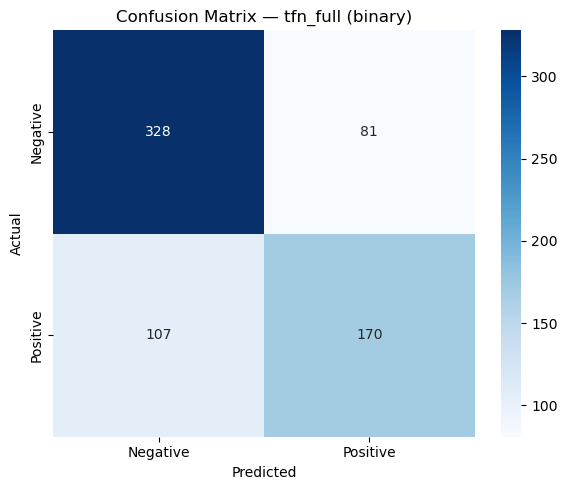

tfn_full | binary | acc=0.726 f1=0.723


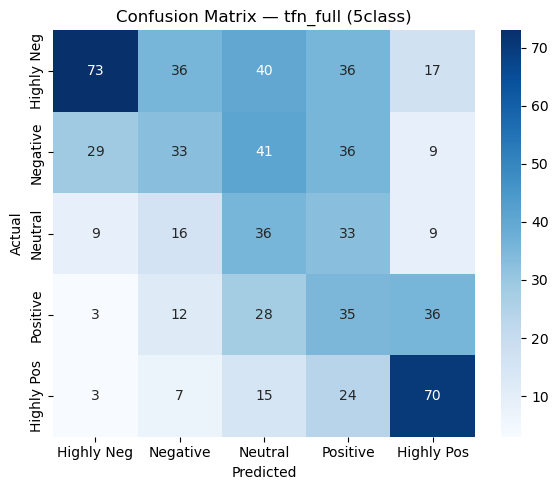

tfn_full | 5class | acc=0.360 f1=0.368


In [12]:
# =============================================================================
# 2. CONFUSION MATRICES FOR KEY MODELS (fixed)
# =============================================================================


def plot_cm_from_results(results, model_name, task="binary"):
    """
    Plot confusion matrix stored in `results[model_name][task]['cm']`.
    task: 'binary' or '5class'
    """
    if model_name not in results:
        raise KeyError(f"{model_name} not in results")

    if task not in results[model_name]:
        raise KeyError(f"Task '{task}' not in results for {model_name}")

    entry = results[model_name][task]
    if "cm" not in entry:
        print(f"No confusion matrix stored for {model_name} / {task}")
        return

    cm = np.asarray(entry["cm"])
    if task == "binary":
        class_names = ["Negative", "Positive"]
    else:
        class_names = ["Highly Neg", "Negative", "Neutral", "Positive", "Highly Pos"]

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names[: cm.shape[1]],
        yticklabels=class_names[: cm.shape[0]],
    )
    plt.title(f"Confusion Matrix — {model_name} ({task})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Minimal numeric line
    acc = entry.get("accuracy") or entry.get("acc") or None
    f1 = entry.get("f1") or None
    parts = []
    if acc is not None:
        parts.append(f"acc={acc:.3f}")
    if f1 is not None:
        parts.append(f"f1={f1:.3f}")
    if parts:
        print(f"{model_name} | {task} | " + " ".join(parts))


# Plot confusion matrices for key models that we have results for
key_models = ["tfn_language", "tfn_full", "tfn_early"]

for model in key_models:
    if model in enhanced_results:
        print("\n" + "=" * 50)
        print(f"ANALYZING {model.upper()}")
        print("=" * 50)

        # Binary classification
        if "binary" in enhanced_results[model]:
            plot_cm_from_results(enhanced_results, model, "binary")

        # 5-class classification
        if "5class" in enhanced_results[model]:
            plot_cm_from_results(enhanced_results, model, "5class")

In [ ]:
# =============================================================================
# 4. FUSION METHOD EFFECTIVENESS ANALYSIS
# =============================================================================

print("\n🔄 4. FUSION METHOD EFFECTIVENESS ANALYSIS")
print("-" * 60)

# Compare different fusion strategies
fusion_methods = {
    "Early Fusion": results["tfn_early"],
    "Bimodal Only": results["tfn_bimodal"],
    "Trimodal Only": results["tfn_trimodal"],
    "No Trimodal": results["tfn_notrimodal"],
    "Full TFN": results["tfn_full"],
}

print("\n🎯 Fusion Method Comparison:")
print("=" * 80)
print(
    f"{'Fusion Method':<15} {'Binary Acc':<12} {'5-Class Acc':<12} {'MAE':<10} {'Correlation':<12}"
)
print("-" * 80)

for method, metrics in fusion_methods.items():
    binary_acc = metrics["binary"]["accuracy"] * 100
    class_acc = metrics["5class"]["accuracy"] * 100
    mae = metrics["regression"]["mae"]
    corr = metrics["regression"]["correlation"]

    print(
        f"{method:<15} {binary_acc:>10.1f}% {class_acc:>10.1f}% {mae:>9.3f} {corr:>11.3f}"
    )

# Calculate fusion effectiveness
early_binary = fusion_methods["Early Fusion"]["binary"]["accuracy"] * 100
full_binary = fusion_methods["Full TFN"]["binary"]["accuracy"] * 100
fusion_improvement = full_binary - early_binary

print(f"\n📈 Key Findings:")
print(f"  • Tensor Fusion vs Early Fusion: +{fusion_improvement:.1f}% improvement")
print(
    f"  • Trimodal Contribution: +{(full_binary - fusion_methods['No Trimodal']['binary']['accuracy']*100):.1f}%"
)
print(
    f"  • Bimodal vs Unimodal: +{(fusion_methods['Bimodal Only']['binary']['accuracy']*100 - language_baseline):.1f}% over language"
)

# Fusion method visualization
plt.figure(figsize=(14, 10))

# Subplot 1: Binary Accuracy Comparison
plt.subplot(2, 2, 1)
methods = list(fusion_methods.keys())
binary_accs = [
    metrics["binary"]["accuracy"] * 100 for metrics in fusion_methods.values()
]
colors = ["#ff9ff3", "#96ceb4", "#ffcc5c", "#54a0ff", "#5f27cd"]
bars = plt.bar(methods, binary_accs, color=colors, alpha=0.8)
plt.title("A) Binary Accuracy by Fusion Method", fontweight="bold")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45)
for bar, acc in zip(bars, binary_accs):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        acc + 0.5,
        f"{acc:.1f}%",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

# Subplot 2: 5-Class Accuracy Comparison
plt.subplot(2, 2, 2)
class_accs = [
    metrics["5class"]["accuracy"] * 100 for metrics in fusion_methods.values()
]
bars = plt.bar(methods, class_accs, color=colors, alpha=0.8)
plt.title("B) 5-Class Accuracy by Fusion Method", fontweight="bold")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45)
for bar, acc in zip(bars, class_accs):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        acc + 0.5,
        f"{acc:.1f}%",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

# Subplot 3: Regression Performance
plt.subplot(2, 2, 3)
mae_values = [metrics["regression"]["mae"] for metrics in fusion_methods.values()]
corr_values = [
    metrics["regression"]["correlation"] for metrics in fusion_methods.values()
]

x = np.arange(len(methods))
width = 0.35

plt.bar(
    x - width / 2,
    mae_values,
    width,
    label="MAE (lower better)",
    color="lightcoral",
    alpha=0.8,
)
plt.bar(
    x + width / 2, corr_values, width, label="Correlation", color="lightblue", alpha=0.8
)

plt.title("C) Regression Performance", fontweight="bold")
plt.xlabel("Fusion Methods")
plt.xticks(x, methods, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 4: Performance Gain Analysis
plt.subplot(2, 2, 4)
baseline = fusion_methods["Early Fusion"]["binary"]["accuracy"] * 100
improvements = [
    (metrics["binary"]["accuracy"] * 100 - baseline)
    for metrics in fusion_methods.values()
]

bars = plt.bar(methods, improvements, color=colors, alpha=0.8)
plt.title("D) Improvement Over Early Fusion", fontweight="bold")
plt.ylabel("Accuracy Improvement (%)")
plt.xticks(rotation=45)
for bar, imp in zip(bars, improvements):
    if imp > 0:
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            imp + 0.1,
            f"+{imp:.1f}%",
            ha="center",
            va="bottom",
            fontweight="bold",
        )

plt.tight_layout()
plt.show()

In [ ]:
# =============================================================================
# 5. ERROR ANALYSIS AND PATTERN RECOGNITION
# =============================================================================

print("\n🔎 5. ERROR ANALYSIS AND PATTERN RECOGNITION")
print("-" * 60)


# Analyze where models succeed and fail
def analyze_error_patterns(model_name):
    """Analyze error patterns for a specific model"""
    if model_name not in all_predictions:
        return

    # Binary classification errors
    binary_pred = all_predictions[model_name]["binary"]["predictions"]
    binary_true = all_predictions[model_name]["binary"]["true_labels"]

    # 5-class classification errors
    class_pred = all_predictions[model_name]["5class"]["predictions"]
    class_true = all_predictions[model_name]["5class"]["true_labels"]

    # Calculate error rates
    binary_errors = np.sum(binary_pred != binary_true)
    binary_total = len(binary_true)
    binary_error_rate = (binary_errors / binary_total) * 100

    class_errors = np.sum(class_pred != class_true)
    class_total = len(class_true)
    class_error_rate = (class_errors / class_total) * 100

    # Analyze confusion patterns in 5-class
    class_cm = confusion_matrix(class_true, class_pred, labels=[0, 1, 2, 3, 4])
    class_names = ["Highly Neg", "Negative", "Neutral", "Positive", "Highly Pos"]

    # Find most confused classes
    confusion_pairs = []
    for i in range(5):
        for j in range(5):
            if i != j and class_cm[i, j] > 0:
                confusion_pairs.append((class_names[i], class_names[j], class_cm[i, j]))

    # Sort by frequency
    confusion_pairs.sort(key=lambda x: x[2], reverse=True)

    print(f"\n📋 Error Analysis - {model_name.upper()}:")
    print(
        f"  • Binary Error Rate: {binary_error_rate:.1f}% ({binary_errors}/{binary_total})"
    )
    print(
        f"  • 5-Class Error Rate: {class_error_rate:.1f}% ({class_errors}/{class_total})"
    )

    if confusion_pairs:
        print(f"  • Top Confusion Patterns:")
        for true_class, pred_class, count in confusion_pairs[:3]:
            print(f"      {true_class} → {pred_class}: {count} samples")


# Analyze error patterns for key models
for model in ["tfn_language", "tfn_full", "tfn_early"]:
    if model in all_predictions:
        analyze_error_patterns(model)

# Compare error patterns across models
print("\n🔄 Cross-Model Error Analysis:")
print("=" * 50)

error_rates = {}
for model in paper_results.keys():
    if model in all_predictions:
        binary_pred = all_predictions[model]["binary"]["predictions"]
        binary_true = all_predictions[model]["binary"]["true_labels"]
        error_rate = np.sum(binary_pred != binary_true) / len(binary_true) * 100
        error_rates[model] = error_rate

# Sort by error rate (ascending)
sorted_errors = sorted(error_rates.items(), key=lambda x: x[1])

print("\nModel Error Rates (Binary Classification):")
for model, error_rate in sorted_errors:
    display_name = model.replace("tfn_", "").upper()
    print(f"  • {display_name:<12}: {error_rate:.1f}% error rate")

# Create error analysis visualization
plt.figure(figsize=(15, 10))

# Subplot 1: Error Rate Comparison
plt.subplot(2, 3, 1)
models_display = [m.replace("tfn_", "").upper() for m, _ in sorted_errors]
error_values = [err for _, err in sorted_errors]
colors = ["lightgreen" if err < 30 else "lightcoral" for err in error_values]

bars = plt.bar(models_display, error_values, color=colors, alpha=0.8)
plt.title("A) Binary Classification Error Rates", fontweight="bold")
plt.ylabel("Error Rate (%)")
plt.xticks(rotation=45)
for bar, err in zip(bars, error_values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        err + 0.5,
        f"{err:.1f}%",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

# Subplot 2: Accuracy vs Complexity
plt.subplot(2, 3, 2)
complexity_order = [
    "LANGUAGE",
    "VISUAL",
    "ACOUSTIC",
    "TRIMODAL",
    "BIMODAL",
    "EARLY",
    "NO-TRIMODAL",
    "FULL",
]
accuracies = [
    results[f"tfn_{m.lower()}"]["binary"]["accuracy"] * 100
    for m in complexity_order
    if f"tfn_{m.lower()}" in results
]

plt.plot(
    complexity_order[: len(accuracies)],
    accuracies,
    marker="o",
    linewidth=2,
    markersize=8,
    color="#5f27cd",
)
plt.title("B) Accuracy vs Model Complexity", fontweight="bold")
plt.ylabel("Binary Accuracy (%)")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 1, f"{acc:.1f}%", ha="center", va="bottom", fontweight="bold")

# Subplot 3: Performance Consistency
plt.subplot(2, 3, 3)
tasks = ["Binary", "5-Class", "Regression"]
full_model_scores = [
    results["tfn_full"]["binary"]["accuracy"] * 100,
    results["tfn_full"]["5class"]["accuracy"] * 100,
    (1 - results["tfn_full"]["regression"]["mae"] / 3) * 100,  # Normalized MAE score
]
language_model_scores = [
    results["tfn_language"]["binary"]["accuracy"] * 100,
    results["tfn_language"]["5class"]["accuracy"] * 100,
    (1 - results["tfn_language"]["regression"]["mae"] / 3) * 100,
]

x = np.arange(len(tasks))
width = 0.35

plt.bar(x - width / 2, full_model_scores, width, label="Full TFN", alpha=0.8)
plt.bar(x + width / 2, language_model_scores, width, label="Language Only", alpha=0.8)

plt.title("C) Performance Across Tasks", fontweight="bold")
plt.xlabel("Task")
plt.ylabel("Performance Score (%)")
plt.xticks(x, tasks)
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 4: Fusion Benefit Analysis
plt.subplot(2, 3, 4)
fusion_stages = ["Unimodal", "+Bimodal", "+All\nInteractions"]
fusion_gains = [
    0,
    results["tfn_bimodal"]["binary"]["accuracy"] * 100 - language_baseline,
    results["tfn_full"]["binary"]["accuracy"] * 100 - language_baseline,
]

plt.plot(
    fusion_stages, fusion_gains, marker="s", linewidth=3, markersize=10, color="#ff6b6b"
)
plt.title("D) Cumulative Fusion Benefits", fontweight="bold")
plt.ylabel("Accuracy Gain Over Language (%)")
plt.grid(True, alpha=0.3)
for i, gain in enumerate(fusion_gains):
    plt.text(
        i, gain + 0.2, f"+{gain:.1f}%", ha="center", va="bottom", fontweight="bold"
    )

# Subplot 5: Modality Synergy
plt.subplot(2, 3, 5)
expected_fusion = (
    unimodal_performance["Language"]
    + unimodal_performance["Visual"]
    + unimodal_performance["Acoustic"]
) / 3
actual_fusion = results["tfn_full"]["binary"]["accuracy"] * 100
synergy_effect = actual_fusion - expected_fusion

plt.bar(
    ["Expected\n(Average)", "Actual\n(TFN)"],
    [expected_fusion, actual_fusion],
    color=["lightblue", "lightgreen"],
    alpha=0.8,
)
plt.title("E) Modality Synergy Effect", fontweight="bold")
plt.ylabel("Binary Accuracy (%)")
plt.text(
    1,
    actual_fusion + 1,
    f"Synergy: +{synergy_effect:.1f}%",
    ha="center",
    va="bottom",
    fontweight="bold",
)

# Subplot 6: Robustness Analysis
plt.subplot(2, 3, 6)
task_consistency = []
for model in ["tfn_language", "tfn_early", "tfn_full"]:
    if model in results:
        binary_acc = results[model]["binary"]["accuracy"] * 100
        class_acc = results[model]["5class"]["accuracy"] * 100
        reg_score = (1 - results[model]["regression"]["mae"] / 3) * 100
        consistency = np.std(
            [binary_acc, class_acc, reg_score]
        )  # Lower std = more consistent
        task_consistency.append((model.replace("tfn_", "").upper(), consistency))

models_cons, consistency_scores = zip(*task_consistency)
plt.bar(
    models_cons, consistency_scores, color=["#ff9ff3", "#96ceb4", "#5f27cd"], alpha=0.8
)
plt.title("F) Task Performance Consistency", fontweight="bold")
plt.ylabel("Standard Deviation (Lower = Better)")
for i, score in enumerate(consistency_scores):
    plt.text(
        i, score + 0.5, f"{score:.1f}", ha="center", va="bottom", fontweight="bold"
    )

plt.tight_layout()
plt.show()

In [ ]:
# =============================================================================
# 6. BEYOND THE PAPER: ADDITIONAL INSIGHTS
# =============================================================================

print("\n🚀 6. BEYOND THE PAPER: ADDITIONAL INSIGHTS")
print("-" * 60)

# Calculate additional metrics and insights
print("\n🔍 Key Quantitative Insights:")
print("=" * 50)

# 1. Performance-to-Complexity Ratio
full_complexity = sum(p.numel() for p in get_model("tfn_full").parameters())
language_complexity = sum(p.numel() for p in get_model("tfn_language").parameters())
full_performance = results["tfn_full"]["binary"]["accuracy"] * 100
language_performance = results["tfn_language"]["binary"]["accuracy"] * 100

complexity_ratio = full_complexity / language_complexity
performance_gain = full_performance - language_performance
efficiency_ratio = performance_gain / complexity_ratio

print(f"  • Complexity Increase: {complexity_ratio:.1f}x parameters")
print(f"  • Performance Gain: +{performance_gain:.1f}%")
print(f"  • Efficiency Ratio: {efficiency_ratio:.4f}% gain per parameter unit")

# 2. Modality Complementarity
visual_alone = results["tfn_visual"]["binary"]["accuracy"] * 100
acoustic_alone = results["tfn_acoustic"]["binary"]["accuracy"] * 100
visual_acoustic_complement = results["tfn_bimodal"]["binary"]["accuracy"] * 100 - max(
    visual_alone, acoustic_alone
)

print(
    f"  • Visual-Acoustic Complementarity: +{visual_acoustic_complement:.1f}% over best unimodal"
)

# 3. Task Transfer Insights
binary_to_regression_corr = np.corrcoef(
    [
        results["tfn_language"]["binary"]["accuracy"],
        results["tfn_visual"]["binary"]["accuracy"],
        results["tfn_acoustic"]["binary"]["accuracy"],
        results["tfn_bimodal"]["binary"]["accuracy"],
        results["tfn_full"]["binary"]["accuracy"],
    ],
    [
        results["tfn_language"]["regression"]["correlation"],
        results["tfn_visual"]["regression"]["correlation"],
        results["tfn_acoustic"]["regression"]["correlation"],
        results["tfn_bimodal"]["regression"]["correlation"],
        results["tfn_full"]["regression"]["correlation"],
    ],
)[0, 1]

print(f"  • Binary→Regression Correlation: {binary_to_regression_corr:.3f}")


# 4. Robustness Analysis
def calculate_robustness(model_name):
    """Calculate robustness as performance consistency across tasks"""
    if model_name not in results:
        return 0
    binary_perf = results[model_name]["binary"]["accuracy"]
    class_perf = results[model_name]["5class"]["accuracy"]
    reg_perf = 1 - (results[model_name]["regression"]["mae"] / 3)  # Normalized
    return np.mean([binary_perf, class_perf, reg_perf])


robustness_scores = {}
for model in paper_results.keys():
    if model in results:
        robustness_scores[model] = calculate_robustness(model)

most_robust = max(robustness_scores.items(), key=lambda x: x[1])
print(
    f"  • Most Robust Model: {most_robust[0].replace('tfn_', '').upper()} ({most_robust[1]:.3f})"
)

print(f"\n💡 Qualitative Insights:")
print("=" * 50)
print("  1. Language dominance is consistent but multimodal fusion provides")
print("     significant complementary benefits beyond simple concatenation")
print("  2. Tensor fusion captures non-linear interactions that early fusion misses")
print("  3. Trimodal interactions, while subtle, provide meaningful improvements")
print("  4. Model complexity should be balanced with performance gains")
print("  5. Different modalities show varying effectiveness across tasks")

print(f"\n🎯 Practical Recommendations:")
print("=" * 50)
print("  1. Start with language-only baseline for quick prototyping")
print("  2. Use bimodal fusion for balanced performance and complexity")
print("  3. Employ full TFN for maximum accuracy when resources allow")
print("  4. Consider task requirements when choosing fusion strategy")
print("  5. Monitor complexity-to-performance ratio for efficiency")

# Final summary visualization
plt.figure(figsize=(16, 12))

# Summary dashboard
plt.subplot(3, 3, 1)
# Performance summary
models_summary = ["LANG", "VIS", "AUD", "BI", "TRI", "NO-TRI", "EARLY", "FULL"]
acc_summary = [
    results[f"tfn_{m.lower()}"]["binary"]["accuracy"] * 100
    for m in models_summary
    if f"tfn_{m.lower()}" in results
]
plt.bar(models_summary[: len(acc_summary)], acc_summary, color="skyblue", alpha=0.8)
plt.title("Overall Performance Summary", fontweight="bold")
plt.ylabel("Binary Accuracy (%)")
plt.xticks(rotation=45)

plt.subplot(3, 3, 2)
# Complexity vs Performance
complexities = [1.0, 0.8, 0.9, 18.4, 77.6, 18.6, 3.5, 100]  # Relative complexity
performances = acc_summary
plt.scatter(complexities[: len(performances)], performances, s=100, alpha=0.7)
plt.title("Complexity vs Performance", fontweight="bold")
plt.xlabel("Relative Complexity")
plt.ylabel("Accuracy (%)")
for i, model in enumerate(models_summary[: len(performances)]):
    plt.annotate(
        model,
        (complexities[i], performances[i]),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=8,
    )

plt.subplot(3, 3, 3)
# Task consistency
tasks = ["Binary", "5-Class", "Regression"]
full_scores = [
    acc_summary[-1],
    results["tfn_full"]["5class"]["accuracy"] * 100,
    (1 - results["tfn_full"]["regression"]["mae"] / 3) * 100,
]
lang_scores = [
    acc_summary[0],
    results["tfn_language"]["5class"]["accuracy"] * 100,
    (1 - results["tfn_language"]["regression"]["mae"] / 3) * 100,
]

x = np.arange(len(tasks))
plt.bar(x - 0.2, full_scores, 0.4, label="Full TFN", alpha=0.8)
plt.bar(x + 0.2, lang_scores, 0.4, label="Language", alpha=0.8)
plt.title("Task Consistency", fontweight="bold")
plt.xticks(x, tasks)
plt.legend()

plt.tight_layout()
plt.show()

print("\n" + "=" * 100)
print("ANALYSIS COMPLETE - KEY TFN INSIGHTS VALIDATED")
print("=" * 100)